<a href="https://colab.research.google.com/github/victor-m-olsen/earth-engine/blob/main/water_level_estimates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install packages { display-mode: "form" }
%%capture
# !pip install geopandas
# !pip install folium
!pip install geemap
!pip install pandas
!pip install numpy

In [ ]:
# Import libraries
import geemap
import ee
import pandas as pd
import numpy  as np
from pprint import pprint 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sb 
from scipy.stats import linregress

import io
import datetime as dt # check whether I need this 
from datetime import datetime, timedelta # needed for datetime.strptime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Trigger the authentication flow.
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=x_UTLCk5krVmeX7HjPGmthQEOJ7GpnNh0glRH20SLFQ&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWgRFZYQStf4gbqOEwzawfmy5WWle6zz8ubBuZPGSeKbtGRw8k8A_8Y

Successfully saved authorization token.


# Define functions and AOIs/POIs

### Functions

In [ ]:
def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focal_min(2).focal_max(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select(['QA60', 'B1','B2','B3','B4','B5','B6','B7','B8','B8A', 'B9', 'B11','B12'])\
              .updateMask(not_cld_shdw);




def add_cloud_percentage(img):
  
  cloudmask = img.select('cloudmask')
  cloud_area = cloudmask.eq(1).multiply(ee.Image.pixelArea()).rename('cloud_area')#.divide(1000000)
  total_area = cloudmask.eq(1).Or(cloudmask.eq(0)).multiply(ee.Image.pixelArea()).rename('total_area')#.divide(1000000)
  
  area = cloud_area.addBands(total_area).reduceRegion(
    geometry = aoi,\
    reducer = ee.Reducer.sum(),\
    scale = 10,\
    maxPixels = 20000000000,\
    tileScale = 16
  )
  
  perc = ee.Number(area.get('cloud_area')).divide(ee.Number(area.get('total_area')))
  
  return img.set('cloud_perc', perc)


def add_water_extent (img):
  # calculate water extent based on MNDWI and NDWI thresholds
  
  water_MNDWI = img.select('MNDWI').gte(0).rename('water_MNDWI')
  water_NDWI = img.select('NDWI').lte(0).rename('water_NDWI')
  water = water_MNDWI.Or(water_NDWI).rename('water')

  water_area = water.multiply(ee.Image.pixelArea()).divide(1000000)
  
  water_extent = water_area.reduceRegion(\
    geometry = aoi,\
    reducer= ee.Reducer.sum(),\
    scale= 10,\
    maxPixels= 20000000000,\
    tileScale= 16\
  ).get('water')
  
  return img.addBands(water_MNDWI).addBands(water_NDWI).addBands(water)\
                .set('water_extent', water_extent)\
                .set('date', ee.Image(img).date().format('YYYY-MM-dd'))


# def add_date_info(df):
#   # df['timestamp'] = pd.to_datetime(df['system:time_start'], unit='ms')
#   # df['year'] = pd.DatetimeIndex(df['timestamp']).year
#   # df['month'] = pd.DatetimeIndex(df['timestamp']).month{}
#   # df['day'] = pd.DatetimeIndex(df['timestamp']).day
#   # df['DOY'] = pd.DatetimeIndex(df['timestamp']).dayofyear
#   df['date'] = pd.to_datetime(df['date']) #convert date (object) into datetime object

#   return df

### AOIs and POIs

In [ ]:
dam_Tishrin = ee.Geometry.Point([38.17848300813228, 36.380737152690656])
dam_Tabqa = ee.Geometry.Point([38.56510446209167, 35.870972690621606])
dam_Hurriyah = ee.Geometry.Point([38.74803072140846, 35.885044983958736])
reservoir_Sfan = ee.Geometry.Point([42.071207224523334, 37.144020048857186])
dam_Ataturk = ee.Geometry.Point([38.31898521956248, 37.48005598838871])
reservoir_Hasakah_East_dam = ee.Geometry.Point([40.66850348121576, 36.5944455085102])
reservoir_Hasakah_South_dam = ee.Geometry.Point([40.78126590402885, 36.33075273410688])
reservoir_Tishrin = ee.Geometry.Point([38.0779886916235, 36.68440324822885])
dam_Keban = ee.Geometry.Point([38.75443695803264, 38.80563795291479])
dam_Karakaya = ee.Geometry.Point([39.13490538388588, 38.22603907121886])
dam_Turkey1 = ee.Geometry.Point([38.032466765799605, 36.86769530173293])
dam_Turkey2 = ee.Geometry.Point([37.89014943088281, 37.05443529585137])
lake_Ataturk = ee.Geometry.Point([38.553628655862695, 37.539145487341955])
AOI_Tishrin = ee.Geometry.Polygon([[[38.010548494142455, 36.77219104042317],\
          [38.01569839600435, 36.74110824284246],\
          [38.026176043583746, 36.73367716123688],\
          [38.036649936886825, 36.713587869904266],\
          [38.05072899823461, 36.69652043842134],\
          [38.05930093279661, 36.6568744618735],\
          [38.12523045780217, 36.655512147126174],\
          [38.192511492994484, 36.629602547847256],\
          [38.21019180731715, 36.62946544648836],\
          [38.220320960050884, 36.64034714332425],\
          [38.21843376953154, 36.658387455299525],\
          [38.21036454323464, 36.67477505064971],\
          [38.172598576085775, 36.680832692000756],\
          [38.11903965180163, 36.68964304884765],\
          [38.099815185832384, 36.68936793032813],\
          [38.09552421465149, 36.70010393247643],\
          [38.090886883719875, 36.722672753019154],\
          [38.08814355046176, 36.73340056056873],\
          [38.07724271024235, 36.74990858376371],\
          [38.074407177125046, 36.75761400853883],\
          [38.0593008500423, 36.77659110765869]]]);

AOI_Tishrin4 = ee.Geometry.Polygon(\
        [[[38.20950266285749, 36.67555745924999],\
          [38.123671974380926, 36.68987460378995],\
          [38.098952736099676, 36.68932399366404],\
          [38.086249794205145, 36.656555595890026],\
          [38.12264200611921, 36.65600474728129],\
          [38.19164987965436, 36.63038593482923],\
          [38.2101893083653, 36.63066145124621],\
          [38.220832313736395, 36.640854866174756],\
          [38.218085731705145, 36.65793270016911]]]);

AOI_Assad = ee.Geometry.Polygon(\
        [[[38.195303453856226, 36.3722378548376],\
          [38.16852427905154, 36.3755550285924],\
          [38.159597887449976, 36.34569537289177],\
          [38.15753795092654, 36.31969708973381],\
          [38.165091051512476, 36.29590382756327],\
          [38.14655162280154, 36.28538821314512],\
          [38.082693590574976, 36.26158448484893],\
          [38.07514048998904, 36.23943496702787],\
          [38.0456147331531, 36.19456296758793],\
          [38.00441600268435, 36.1452294991273],\
          [38.005102648192164, 36.076998438564786],\
          [38.05385447924685, 36.01148530930804],\
          [38.14174510424685, 35.93090726964557],\
          [38.192556871824976, 35.92145480360175],\
          [38.222769274168726, 35.89809680848627],\
          [38.23993541186404, 35.87083710023906],\
          [38.31958629077029, 35.851916687249656],\
          [38.324392809324976, 35.830208299803836],\
          [38.2818207878406, 35.799583811941865],\
          [38.302420153074976, 35.77451862838928],\
          [38.342932238035914, 35.79401445428721],\
          [38.367651476317164, 35.7695046431874],\
          [38.389624132567164, 35.78120345021648],\
          [38.38001109545779, 35.80849397212792],\
          [38.390310778074976, 35.82241409632645],\
          [38.408850206785914, 35.79679918191409],\
          [38.431509508543726, 35.80515277918743],\
          [38.4740815300281, 35.800697636624506],\
          [38.5125336784656, 35.82575456297234],\
          [38.529699816160914, 35.841341548320855],\
          [38.568151964598414, 35.85247323444601],\
          [38.593557848387476, 35.85247323444601],\
          [38.61347056811404, 35.86471628438131],\
          [38.662222399168726, 35.84690758669498],\
          [38.694494738035914, 35.836888436389835],\
          [38.755606188231226, 35.850247022221964],\
          [38.765905870848414, 35.87640106802499],\
          [38.72951365893435, 35.89475938916923],\
          [38.71509410327029, 35.87695744331241],\
          [38.689001573973414, 35.86861140371863],\
          [38.66908885424685, 35.866942090302544],\
          [38.631323351317164, 35.88029561297686],\
          [38.581884874754664, 35.895315635493176],\
          [38.5619721550281, 35.90477122499329],\
          [38.5619726618351, 35.91478145035245],\
          [38.552359117918726, 35.92145480360177],\
          [38.530386461668726, 35.91589400165712],\
          [38.486441149168726, 35.920898741],\
          [38.45966197436404, 35.959813680125436],\
          [38.434945208114726, 35.9695410805609],\
          [38.408850206785914, 35.97481860670017],\
          [38.39889350263787, 35.96398042518267],\
          [38.40541697924685, 35.94313819535185],\
          [38.392370714598414, 35.93368719167254],\
          [38.338125719481226, 35.967594368381974],\
          [38.2653412956531, 35.99648735470795],\
          [38.20148326342654, 36.045359072283034],\
          [38.14723826830935, 36.06867352305101],\
          [38.1170258659656, 36.088651839834526],\
          [38.110159410887476, 36.13025702731604],\
          [38.14174510424685, 36.17627440532917],\
          [38.13075877612185, 36.200104113041334],\
          [38.156851305418726, 36.23168115260231],\
          [38.194616808348414, 36.235004310089046],\
          [38.22414256518435, 36.25272543114413],\
          [38.231009020262476, 36.30199116707763],\
          [38.225515856199976, 36.317484069299304],\
          [38.20148326342654, 36.33352704384245]]]);

AOI_Ataturk = ee.Geometry.Polygon(\
        [[[39.13723712915855, 38.22534648854939],\
          [39.13601404184776, 38.22588590375561],\
          [39.13294559473472, 38.2269310093349],\
          [39.13047796244102, 38.224301360204734],\
          [39.12650829309898, 38.21948008990802],\
          [39.121615943855815, 38.214759655630104],\
          [39.11805397028404, 38.21192724807764],\
          [39.10869842524009, 38.209229614588246],\
          [39.10519328705667, 38.20594514656979],\
          [39.10442081086038, 38.203871179270266],\
          [39.105510878619, 38.2000771129641],\
          [39.11084720151364, 38.194326117859575],\
          [39.11458083646237, 38.191071298237944],\
          [39.12240434578691, 38.18639889805946],\
          [39.12841249398027, 38.18557246872752],\
          [39.13175989083086, 38.18678681063505],\
          [39.13587976387773, 38.188068594020585],\
          [39.14038587502275, 38.186027849315074],\
          [39.14470899920083, 38.18421521210762],\
          [39.15168274263955, 38.182056291845925],\
          [39.155824073358545, 38.181432217038385],\
          [39.162347205682764, 38.18198882455686],\
          [39.16959989885903, 38.1841140141495],\
          [39.177796729608545, 38.19025310251304],\
          [39.18371904711343, 38.1950763089693],\
          [39.19496286730386, 38.20360889172136],\
          [39.201786407037744, 38.20394612741424],\
          [39.205262549921045, 38.20337282580682],\
          [39.208524116083154, 38.20428336154495],\
          [39.211485274835596, 38.20414846808013],\
          [39.21813715319253, 38.204317084872095],\
          [39.22302950243569, 38.20327165446624],\
          [39.226763137384424, 38.20043879984876],\
          [39.227707274957666, 38.19531240178383],\
          [39.23015344957925, 38.19099515506632],\
          [39.234702476068506, 38.18755466586216],\
          [39.2424272380314, 38.185058522958364],\
          [39.24856413225747, 38.18161775335035],\
          [39.25105322222329, 38.17912140702144],\
          [39.253928550287256, 38.17244157329582],\
          [39.25358522753335, 38.16846037110698],\
          [39.25538767199136, 38.1633317223981],\
          [39.257447608514795, 38.15850641428512],\
          [39.25882089953042, 38.15499689872168],\
          [39.259679206415186, 38.14848360018003],\
          [39.25839174608804, 38.14450108968628],\
          [39.25495886444245, 38.13849479483458],\
          [39.250366922608954, 38.13339779475056],\
          [39.24792074798737, 38.13066349569041],\
          [39.24603247284089, 38.129954586620656],\
          [39.24423002838288, 38.12759150666362],\
          [39.239337679139716, 38.12549842910368],\
          [39.235089060060126, 38.12293263925995],\
          [39.23332953094636, 38.120839428128875],\
          [39.2322566473404, 38.11942141230049],\
          [39.23320078491364, 38.117496918202036],\
          [39.23041128753815, 38.113749073616624],\
          [39.231355425111396, 38.11114910447716],\
          [39.228866335145575, 38.10800875861591],\
          [39.23045420288239, 38.106556725102976],\
          [39.22745012878571, 38.09784391795425],\
          [39.22547602295075, 38.09544400892028],\
          [39.223416086427314, 38.08966847924965],\
          [39.220412012330634, 38.08372359787401],\
          [39.216420885316474, 38.08227108178348],\
          [39.21470427154694, 38.07872411891078],\
          [39.21676585840673, 38.076512052114126],\
          [39.213032223458, 38.07161343428125],\
          [39.20723865198583, 38.07157964957087],\
          [39.20706699060888, 38.07492426020253],\
          [39.2040629165122, 38.077559300253206],\
          [39.200973011727044, 38.07367427210734],\
          [39.19874141382665, 38.07087016704797],\
          [39.19650981592626, 38.06860653394995],\
          [39.19264743494482, 38.07012689226221],\
          [39.189214207405755, 38.06901196592281],\
          [39.184708096260735, 38.063200559604326],\
          [39.17561004328222, 38.062322051044085],\
          [39.172691799874016, 38.05995678326332],\
          [39.18342063593359, 38.05644252995832],\
          [39.19011542963476, 38.05718594376938],\
          [39.180073239083, 38.04738579178653],\
          [39.17234847712011, 38.04035590924239],\
          [39.170202709908196, 38.03433941613608],\
          [39.17131850885839, 38.02967460382325],\
          [39.1606755034873, 38.024806656867824],\
          [39.152521588082024, 38.02034408802428],\
          [39.1375870482871, 38.028187209903386],\
          [39.125333303262586, 38.03023605901279],\
          [39.103103154947156, 38.024962475627],\
          [39.08404874210536, 38.01367032201008],\
          [39.075637334634656, 38.00460829389206],\
          [39.06473683719813, 38.001767726155485],\
          [39.055724614908094, 38.00677246211784],\
          [39.04010342960536, 38.00548749493794],\
          [39.035726064493055, 38.00677246211784],\
          [39.03452443485438, 38.01096535627177],\
          [39.0216498315829, 38.00832791857328],\
          [39.0190749109286, 38.00332328878422],\
          [39.01109265690028, 38.00332328878422],\
          [39.01014851932704, 38.0095452093016],\
          [39.00362538700282, 38.01164160706415],\
          [39.00036382084071, 38.00345855354026],\
          [38.994784826089735, 38.0004826712683],\
          [38.987317556192274, 37.99906232124644],\
          [38.974013799478406, 37.99344828765313],\
          [38.957534307290906, 37.98573674592543],\
          [38.95650433902919, 37.979445151003524],\
          [38.969550603677625, 37.977753770052615],\
          [38.984313482095594, 37.981745366541965],\
          [38.991780751993055, 37.98269249316079],\
          [39.00044965152919, 37.98330135381765],\
          [39.015727514078016, 37.990269066024645],\
          [39.02216481571376, 37.98478965859965],\
          [39.02963208561122, 37.98221893137941],\
          [39.040446752359266, 37.97728017640129],\
          [39.04482411747157, 37.97315301666448],\
          [39.04525327091395, 37.96347696207889],\
          [39.04182004337489, 37.954070344190356],\
          [39.03901284217436, 37.94664338535454],\
          [39.032833032604046, 37.93682845047896],\
          [39.031888895030804, 37.931886642357455],\
          [39.02390664100248, 37.92349157671845],\
          [39.02004426002104, 37.92051245205826],\
          [39.003135614391155, 37.91895513431994],\
          [38.987171106334515, 37.914486126430724],\
          [38.97197907447416, 37.90683401283721],\
          [38.960477762218304, 37.90338014338894],\
          [38.95884697913725, 37.89877473195471],\
          [38.95953362464506, 37.889833992982666],\
          [38.975927286144085, 37.88543095736821],\
          [38.98150628089506, 37.88339869828364],\
          [38.972923212047405, 37.874388340893155],\
          [38.95936196326811, 37.86883253368529],\
          [38.96605675696928, 37.86225987936522],\
          [38.96734421729643, 37.85419571922375],\
          [38.96785920142729, 37.843012861061176],\
          [38.96751587867338, 37.83548889317994],\
          [38.95987694739897, 37.833251889864286],\
          [38.94485657691557, 37.8364379043968],\
          [38.947946481700725, 37.84518179035961],\
          [38.94305413245756, 37.85155265126536],\
          [38.93258278846342, 37.84701177483821],\
          [38.930952005382366, 37.83772582866347],\
          [38.92082398414213, 37.83711576207701],\
          [38.91893570899565, 37.8350143829933],\
          [38.91155426978666, 37.84050495704343],\
          [38.911468439098186, 37.8454529020368],\
          [38.90245621680815, 37.847282879787606],\
          [38.891298227306194, 37.847079551169024],\
          [38.88494675635893, 37.839217081300696],\
          [38.8887233066519, 37.826540472938454],\
          [38.90108292579252, 37.82220145429548],\
          [38.89121239661772, 37.817387557007045],\
          [38.87593453406889, 37.81779437737306],\
          [38.87438958167631, 37.80124854092552],\
          [38.87833779334623, 37.79460203848384],\
          [38.885032587047405, 37.78402065814758],\
          [38.87009804725248, 37.7860556566568],\
          [38.84812539100248, 37.79528028041618],\
          [38.840572290416546, 37.793652489317935],\
          [38.8407439517935, 37.787954938042944],\
          [38.85911171912748, 37.762853352161166],\
          [38.87490456580717, 37.745345041228575],\
          [38.87559121131498, 37.73434933326342],\
          [38.86649315833647, 37.73638569870311],\
          [38.862544946666546, 37.74751683974365],\
          [38.81276314735014, 37.74453060035452],\
          [38.82306282996733, 37.72701795393624],\
          [38.81482308387358, 37.72036477790033],\
          [38.78352646799635, 37.71874239789872],\
          [38.772711801248306, 37.73517094492336],\
          [38.766531991677994, 37.7404653198105],\
          [38.74558930368971, 37.73164115131893],\
          [38.74473099680495, 37.72621037104557],\
          [38.766531991677994, 37.695926472435794],\
          [38.7859297272737, 37.691715623359315],\
          [38.79276455038098, 37.67355355776765],\
          [38.79654110067395, 37.66703146503749],\
          [38.7718218623927, 37.66553673805807],\
          [38.77147853963879, 37.678308889017956],\
          [38.75431240194348, 37.67667852406596],\
          [38.74126613729504, 37.68347147500272],\
          [38.74006450765637, 37.6955613886161],\
          [38.72698077413609, 37.70534261859722],\
          [38.7195993349271, 37.72435396208615],\
          [38.72258437937409, 37.75164028921625],\
          [38.73305302531009, 37.784209935161236],\
          [38.7143419352222, 37.783938598487865],\
          [38.70266896158939, 37.75422120667473],\
          [38.68172627360111, 37.78434560312436],\
          [38.672962145353935, 37.812564075627336],\
          [38.660259203459404, 37.834530602367174],\
          [38.62833018734612, 37.88074741605043],\
          [38.624345151652456, 37.92788307985218],\
          [38.61095556425011, 37.94250524971236],\
          [38.57113012479699, 37.96497439459979],\
          [38.54538091825402, 37.98797784068337],\
          [38.50692876981652, 37.97309408114597],\
          [38.50692876981652, 37.95171030878181],\
          [38.54915746854699, 37.94060994733945],\
          [38.58108648466027, 37.93844382763224],\
          [38.596879331339956, 37.92463331377651],\
          [38.601505103527046, 37.8788218384902],\
          [38.62382108253095, 37.836535509309805],\
          [38.64888364356611, 37.78065871088386],\
          [38.66982633155439, 37.70029571628493],\
          [38.68596250098798, 37.67971101443387],\
          [38.72201139014814, 37.6552522407226],\
          [38.6814993051872, 37.65443680945397],\
          [38.667423072277046, 37.653893183633315],\
          [38.61592465919111, 37.73539256998333],\
          [38.584613745096675, 37.754233142370346],\
          [38.573627416971675, 37.733871877203555],\
          [38.612079565409175, 37.71540615563879],\
          [38.639545385721675, 37.66514523494153],\
          [38.60624307859277, 37.664058136134116],\
          [38.5859870361123, 37.64448763523349],\
          [38.59525675046777, 37.61675393047841],\
          [38.56573099363183, 37.60533116174967],\
          [38.55508798826074, 37.62871875870972],\
          [38.533458654764644, 37.606691107168075],\
          [38.514919226053706, 37.585473127354696],\
          [38.48436350095605, 37.57567817310651],\
          [38.47337717283105, 37.562071932339656],\
          [38.48505014646386, 37.54737440077694],\
          [38.477497045877925, 37.52940681487335],\
          [38.46582407224511, 37.52695635408642],\
          [38.46033090818261, 37.535124243647374],\
          [38.4486579345498, 37.53811891236762],\
          [38.42050546872949, 37.530223617246655],\
          [38.40814584958886, 37.512251898949714],\
          [38.382396643045894, 37.51143489981223],\
          [38.39750284421777, 37.53730219646172],\
          [38.384113256815425, 37.5487354051006],\
          [38.38617319333886, 37.57186867623309],\
          [38.41089243162011, 37.56098332570709],\
          [38.42496866453027, 37.57078021276237],\
          [38.4431647704873, 37.564521239105545],\
          [38.464794103983394, 37.59009807446654],\
          [38.462734167459956, 37.59825904478255],\
          [38.46445078122949, 37.60533116174967],\
          [38.48505014646386, 37.61457830027193],\
          [38.4651374267373, 37.62817494465897],\
          [38.468227331522456, 37.64068166110266],\
          [38.527965490702144, 37.67465667034453],\
          [38.52350229490136, 37.7064044139641],\
          [38.497753088358394, 37.72677323201664],\
          [38.48814005124902, 37.721070527446095],\
          [38.465480749491206, 37.68113930318128],\
          [38.414325659159175, 37.6925504192207],\
          [38.38170999753808, 37.666737056047424],\
          [38.369350378397456, 37.698255318839685],\
          [38.34257120359277, 37.73519070769869],\
          [38.32437509763574, 37.73681978601802],\
          [38.31956857908105, 37.68847522218044],\
          [38.29141611326074, 37.6996135635737],\
          [38.28489298093652, 37.6786938356188],\
          [38.2948493407998, 37.661573305654194],\
          [38.326435034159175, 37.61181984705651],\
          [38.278713171366206, 37.62215390694648],\
          [38.246784155252925, 37.66211687524333],\
          [38.18670267331933, 37.65939898749583],\
          [38.204555456522456, 37.62759230892369],\
          [38.23270792234277, 37.5971321335099],\
          [38.226528112772456, 37.57019712740024],\
          [38.230304663065425, 37.559855850113784],\
          [38.25433725583886, 37.54406902772697],\
          [38.278026525858394, 37.51738714394888],\
          [38.29210275876855, 37.49178534923401],\
          [38.31158809048553, 37.47400763043777],\
          [38.38093928677459, 37.450026333087116],\
          [38.46608332974334, 37.41840287287624],\
          [38.55672053677459, 37.37530804971137],\
          [38.607532304352716, 37.37694501458057],\
          [38.645984452790216, 37.362211044658025],\
          [38.661777299469904, 37.386220473982675],\
          [38.615772050446466, 37.410767622218145],\
          [38.56427363736053, 37.453296962890505],\
          [38.63087825161834, 37.45929274609636],\
          [38.656970780915216, 37.45983779346084],\
          [38.67757014614959, 37.48109154171894],\
          [38.61989192349334, 37.51813490268313],\
          [38.659717362946466, 37.5192241350855],\
          [38.66383723599334, 37.551349337300266],\
          [38.662463944977716, 37.56767887796661],\
          [38.69061641079803, 37.58781371553039],\
          [38.77644709927459, 37.60413526215459],\
          [38.84120191420054, 37.58239468651619],\
          [38.87622083509898, 37.59001240836391],\
          [38.85974134291148, 37.62047549913699],\
          [38.89270032728648, 37.63298351125148],\
          [38.89544690931773, 37.66234187528846],\
          [38.92428602064585, 37.65690601676547],\
          [38.91810621107554, 37.632439728406844],\
          [38.93664563978648, 37.622650956789215],\
          [38.985397470841164, 37.640596053255734],\
          [39.05543531263804, 37.62917694777764],\
          [39.12753309095835, 37.66397255523175],\
          [39.029342783341164, 37.689515197161704],\
          [39.07397474134898, 37.724282525342346],\
          [39.24220289076304, 37.690601923029696],\
          [39.26074231947398, 37.71504904458167],\
          [39.1907044776771, 37.72645494179037],\
          [39.174911630997414, 37.71504904458167],\
          [39.11792005384898, 37.7226531711903],\
          [39.0423890479896, 37.73948810229636],\
          [38.99501050795054, 37.728627294517494],\
          [38.966171396622414, 37.715592222366844],\
          [38.941452158341164, 37.71939435536148],\
          [38.97235120619273, 37.74274603396129],\
          [39.03277601088023, 37.76120493806946],\
          [39.02178968275523, 37.77857381740517],\
          [39.0259095558021, 37.798651497974284],\
          [39.05612195814585, 37.80190682400863],\
          [39.04444898451304, 37.8192661397172],\
          [39.00531019056773, 37.82306294597768],\
          [38.9709779151771, 37.79810892968709],\
          [38.96823288062739, 37.80849097748903],\
          [38.98848892310786, 37.816221112550956],\
          [38.992093812023874, 37.82056048276783],\
          [38.9934671030395, 37.83655970565007],\
          [38.987802277600046, 37.85160665545062],\
          [38.988317261730906, 37.86028097882018],\
          [39.000333558117624, 37.87735556985256],\
          [39.006341706310984, 37.88900738370164],\
          [39.00514007667231, 37.89716281019982],\
          [38.990548859631296, 37.901091059350904],\
          [38.98951889136958, 37.90501909884175],\
          [39.008058320080515, 37.91097848250674],\
          [39.01423812965083, 37.91206195495156],\
          [39.0154397592895, 37.90569632583888],\
          [39.024022828137156, 37.90095560597378],\
          [39.034494172131296, 37.90718620329337],\
          [39.03071762183833, 37.915041421897776],\
          [39.03792739967036, 37.92628105162471],\
          [39.04530883887934, 37.921270826466774],\
          [39.054235230480906, 37.91734365461279],\
          [39.065736542736765, 37.919104136892344],\
          [39.06041504005122, 37.92958734519687],\
          [39.04445053199458, 37.93405543545319],\
          [39.05063034156489, 37.948134913024255],\
          [39.05955673316645, 37.95165436094073],\
          [39.05784011939692, 37.95801601200079],\
          [39.07105804542231, 37.97601514525652],\
          [39.07191635230708, 37.98697486135469],\
          [39.08788086036372, 37.99373930114645],\
          [39.09903884986567, 38.002802672540106],\
          [39.12135482886958, 38.01267641407743],\
          [39.1392076120727, 38.01172967458623],\
          [39.1556871042602, 38.00915989147389],\
          [39.17319656470942, 38.02092605493866],\
          [39.18589950660395, 38.03147342316407],\
          [39.19774414161372, 38.044452714907955],\
          [39.20426727393794, 38.04837309021369],\
          [39.2051255808227, 38.05878134386021],\
          [39.2241799936645, 38.06134938657201],\
          [39.240487824475046, 38.06053843545182],\
          [39.257482300793406, 38.057294541099125],\
          [39.27087188819575, 38.04877863429817],\
          [39.28237320045161, 38.04499346881017],\
          [39.287694703137156, 38.0441823364592],\
          [39.290956269299265, 38.04823790835296],\
          [39.30863739112544, 38.049860074206826],\
          [39.32082534888911, 38.05296912495306],\
          [39.339879761730906, 38.05513186497928],\
          [39.37592865089106, 38.06148454421829],\
          [39.44630981544184, 38.0736477100387],\
          [39.59874511817622, 38.10861212167406],\
          [39.61659790137934, 38.12346835758818],\
          [39.60887313941645, 38.12913994129409],\
          [39.58020568946528, 38.12036230360812],\
          [39.56578613380122, 38.11104334889878],\
          [39.51222778419184, 38.096049491970334],\
          [39.45317627051997, 38.077944700669335],\
          [39.409059296643015, 38.07145831163969],\
          [39.387086640393015, 38.07145831163969],\
          [39.348634491955515, 38.064565893006],\
          [39.317907105480906, 38.06132217719278],\
          [39.30486084083247, 38.05997058649694],\
          [39.285978089367624, 38.055239822468266],\
          [39.26915527442622, 38.07416104364466],\
          [39.24546600440669, 38.08064719298218],\
          [39.236539612805124, 38.08375493567055],\
          [39.24168945411372, 38.1065860371738],\
          [39.249053277103144, 38.12132149714767],\
          [39.26467446240588, 38.13550004717746],\
          [39.26965264233752, 38.151295758673484],\
          [39.265017785159785, 38.166008344249484],\
          [39.26364449414416, 38.18193238393142],\
          [39.25094155224963, 38.19245653381507],\
          [39.23669365796252, 38.1985274670828],\
          [39.23120049390002, 38.20891433446896],\
          [39.2191841975133, 38.212556131833146],\
          [39.19669655713244, 38.21039805168838],\
          [39.18296364697619, 38.2056770282794],\
          [39.17077568921252, 38.194075498839794],\
          [39.15944603833361, 38.187059723810954],\
          [39.13627175244494, 38.19232161843846],\
          [39.1258004084508, 38.191512120930426],\
          [39.11515740307971, 38.19582933700286],\
          [39.11103753003283, 38.20405832119404],\
          [39.1258004084508, 38.209588755136316],\
          [39.13472680005236, 38.21768131570588]]]);


# Select AOI

In [ ]:
AOI_name = 'Assad' # select 'Ataturk', 'Assad' or 'Tishrin'

# Compute linear model

### Extract Sentinel-2

In [ ]:
AOI_dict = {'Assad': {'dead_level': 298, 'start': '2017-01-01', 'poi': dam_Tabqa, 'aoi': AOI_Assad, 'dam_name': 'Furat',}, # dam _name = name in csv containing in-situ data 
          'Tishrin': {'dead_level': 320, 'start': '2018-11-01', 'poi': dam_Tishrin, 'aoi': AOI_Tishrin, 'dam_name': 'Tishrin'},
          'Ataturk': {'dead_level': None, 'start': '2017-01-01', 'poi': dam_Ataturk, 'aoi': AOI_Ataturk}} # change to 2017-01-01



start = AOI_dict[AOI_name]['start']
dead_level = AOI_dict[AOI_name]['dead_level']
aoi = AOI_dict[AOI_name]['aoi']
poi = AOI_dict[AOI_name]['poi']
# end = datetime.today().strftime("%Y-%m-%d")
end = '2021-11-14'

In [ ]:
start_date = ee.Date(start)
end_date = ee.Date(end)

# Loading and filtering image collections
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR')\
                    .filterDate(start_date, end_date) 
               
sentinel2 = sentinel2.filterBounds(poi)


sentinel2.size().getInfo()

303

### Pre-process Sentinel-2


Remove odd images

In [ ]:
def remove_images(imgCol):
  
  
  if AOI_name == 'Assad':
    return imgCol\
              .filterMetadata('system:index', 'not_equals', '20171214T081331_20171214T081331_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20180202T081241_20180202T081331_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20180202T081241_20180202T081331_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20190518T080611_20190518T081906_T37SDV')
  
  if AOI_name == 'Tishrin':
    return imgCol
  
  if AOI_name == 'Ataturk':
    return imgCol\
              .filterMetadata('system:index', 'not_equals', '20171229T081329_20171229T081327_T37SDB')\
              .filterMetadata('system:index', 'not_equals', '20200810T080611_20200810T081940_T37SDB')\
              .filterMetadata('system:index', 'not_equals', '20200810T080611_20200810T081158_T37SDB')\
              .filterMetadata('system:index', 'not_equals', '20210107T081321_20210107T081324_T37SDB')\
              .filterMetadata('system:index', 'not_equals', '20210417T080601_20210417T081231_T37SDB')
 


In [ ]:
sentinel2 = remove_images(sentinel2)
sentinel2.size().getInfo()

300

Compute cloud coverage within AOI and filter out cloudy images

In [ ]:
AOI = aoi
START_DATE = start;
END_DATE = end;

CLOUD_FILTER = 50;        
CLD_PRB_THRESH = 40;    
NIR_DRK_THRESH = 0.19;      
CLD_PRJ_DIST = 3.3;         
BUFFER = 33;

s2_sr_col = sentinel2.filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER));

s2_sr_cld_col_eval = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)
s2_cloudMaskAdded = s2_sr_cld_col_eval.map(add_cld_shdw_mask)

s2_cloudMaskAdded = s2_cloudMaskAdded.map(lambda img: img.clip(aoi)).map(add_cloud_percentage) # cloud percentage within AOI

In [ ]:
### filter out cloudy images from AOI based on threshold (in %)
cloud_perc_th = 0.01
s2_filtered = s2_cloudMaskAdded.filterMetadata('cloud_perc', 'less_than', cloud_perc_th)

# problem is that MNDWI has holes because B11 has holes (masked values)
# fill B11 masked values with 1000 so that MNDWI is negative and we can use water = water_MNDWI.or(water_NDWI) to return only NDWI. If pixel in water_MNDWI is masked, it returns masked, not water_NDWI.
s2_filtered = s2_filtered.map(lambda image: image.addBands(image.select('B11').unmask(1000).rename('B11_filled')))


### calculate indices
s2_filtered = s2_filtered.map(lambda image: image.addBands(image.normalizedDifference(['B3','B11_filled']).rename('MNDWI'))\
                              .addBands(image.normalizedDifference(['B8','B3']).rename('NDWI')))
        

 ### Compute surface water extent time series

#### Compute water extent and add as property to each image

In [ ]:
s2_filtered = s2_filtered.map(add_water_extent)

Reduce property values to dictionary and convert it to df

In [ ]:
# propNames = ['system:time_start', 'Date', 'water_extent','cloud_perc']
# n = 4

propNames = ['date', 'water_extent']
n = 2 

propVals = s2_filtered.reduceColumns(reducer = ee.Reducer.toList().repeat(n), selectors = propNames).get('list');  # propVals is a list of ee.Lists 


In [ ]:
dic_EE = ee.Dictionary.fromLists(propNames, propVals) # creates ee.Dictionary that has prop names as key (string) and propVals as list of values

#################################### this is where we convert from Earth Engine to Python ##############
# issue with Ataturk: too many values, so can't convert from EE to Python. Solve by slicing propVals or imageCollection beforehand, convert seperately and then merge to df

dic = dic_EE.getInfo()

# print(type(dic), '\n')
# for prop in dic.keys():
#     print(prop + ':', dic[prop][0:3])

In [ ]:
df = pd.DataFrame(dic)

In [ ]:
df.head()

,date,water_extent
0,2017-05-08,547.177893
1,2017-06-07,548.891996
2,2017-06-17,543.922099
3,2017-06-27,540.773313
4,2017-07-07,538.597992


#### Version 2 Compute water extent and add as property to each image

In [ ]:
### Split the imgCol s2_filtered. For this you need to convert it into ee.List and then use .slice(start, end, step)

# (1) Convert to list
# s2_filtered_list = s2_filtered.toList(s2_filtered.size())

# (2) Slice it
# s2_filtered_list_1 = s2_filtered_list.slice...()
# s2_filtered_list_2 = s2_filtered_list.slice...()
# s2_filtered_list_3 = s2_filtered_list.slice...()

# (3) Convert the lists back to img collections, like this
# s2_filtered_1 = ee.ImageCollection(s2_filtered_list_1)
# s2_filtered_2 = ...

In [ ]:
### (4) write a function so that we don't have to the conversion for each imgCol manually
# use the code from below to create the function, something like this
# it takes an imgCol and spits out a df (dataframe)

# def convert_to_df(imgCol):
#   propNames = ['date', 'water_extent']
#   n = 2 
#   propVals = s2_filtered.reduceColumns(reducer = ee.Reducer.toList().repeat(n), selectors = propNames).get('list');

#   dic_EE = ee.Dictionary.fromLists(propNames, propVals)

#   dic = dic_EE.getInfo()

#   df = pd.DataFrame(dic)

#   return df

In [ ]:
## (5) and then apply the function the the imagecollections

# df1 = convert_to_df(s2_filtered_1)
# df2 = convert_to_df(s2_filtered_2)
# df3 = convert_to_df(s2_filtered_3)

In [ ]:
### (6)now we need to combine the dataframes into one dataframe. This is very easy, but you need to find the right function to use from the pandas library
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

# https://realpython.com/pandas-merge-join-and-concat/


# df_all = ...

###Process dataframes

Check for duplicate dates and drop them

In [ ]:
df['duplicated'] = df['date'].duplicated(keep='first')
# print(df.head())
print('\n', len(df.loc[df['duplicated'] == True]), 'duplicate date(s)')


 0 duplicate date(s)


In [ ]:
# drop rows with duplicate dates (otherwise there will be an issue with reindexing later)
if len(df.loc[df['duplicated'] == True] > 0):
  df = df.drop_duplicates(subset=['date'])
  print(len(df.loc[df['duplicated'] == True]), 'duplicate date(s)')

Convert date (string) into date object

In [ ]:
df['date'] = pd.to_datetime(df['date'])
print(df.dtypes)

date            datetime64[ns]
water_extent           float64
duplicated                bool
dtype: object


Set date as index and fill on daily basis

In [ ]:
df_water_extent = df[['date','water_extent']]
date_range = pd.date_range(start=df_water_extent.date.min(), end = df_water_extent.date.max())

df_water_extent.set_index('date', drop = False, inplace=True) # need to set date as index to be able to fill dates
print(df_water_extent.head())

df_water_extent = df_water_extent.reindex(date_range) # fill dates based on date range
print('\n',df_water_extent.head())

df_water_extent['date'] = df_water_extent.index # fill date values with index values 
print('\n', df_water_extent.head())

                 date  water_extent
date                               
2017-05-08 2017-05-08    547.177893
2017-06-07 2017-06-07    548.891996
2017-06-17 2017-06-17    543.922099
2017-06-27 2017-06-27    540.773313
2017-07-07 2017-07-07    538.597992

                  date  water_extent
2017-05-08 2017-05-08    547.177893
2017-05-09        NaT           NaN
2017-05-10        NaT           NaN
2017-05-11        NaT           NaN
2017-05-12        NaT           NaN

                  date  water_extent
2017-05-08 2017-05-08    547.177893
2017-05-09 2017-05-09           NaN
2017-05-10 2017-05-10           NaN
2017-05-11 2017-05-11           NaN
2017-05-12 2017-05-12           NaN


In [ ]:
# df_water_extent.tail()

Plot water extent time series

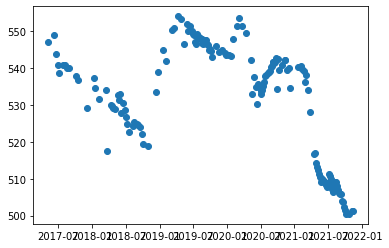

In [ ]:
plt.scatter(df_water_extent.index, df_water_extent['water_extent'])


Interpolate time series

In [ ]:
df_water_extent['water_extent_interp'] = df_water_extent['water_extent'].interpolate(method ='linear', limit_direction ='forward')
df_water_extent.head()

,date,water_extent,water_extent_interp
2017-05-08,2017-05-08,547.177893,547.177893
2017-05-09,2017-05-09,NaN,547.235030
2017-05-10,2017-05-10,NaN,547.292167
2017-05-11,2017-05-11,NaN,547.349303
2017-05-12,2017-05-12,NaN,547.406440


In [ ]:
# df_water_extent.tail()

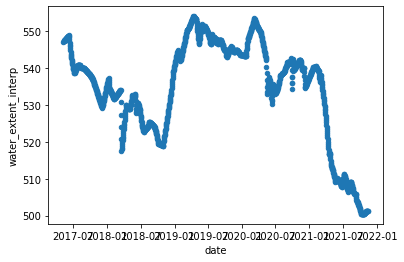

In [ ]:
df_water_extent.plot(x ='date', y='water_extent_interp', kind = 'scatter')

### Fetch CSV files from Google Drive

In [ ]:
df_DAHITI = pd.read_csv('/content/drive/My Drive/REACH/Projects/Water_level_estimates/DAHITI_'+ AOI_name +'_heights.csv')
df_DAHITI = df_DAHITI[['date', 'water level']]

df_in_situ = pd.read_csv('/content/drive/My Drive/REACH/Projects/Water_level_estimates/In_situ_water_levels.csv')
# df_in_situ.head()

FileNotFoundError: ignored

### Upload CSV files from local drive
not necessary if using Google Drive

In [ ]:
# from google.colab import files
# uploaded_DAHITI = files.upload()
# uploaded_in_situ = files.upload()

Convert csv to df

In [ ]:

# df_DAHITI = pd.read_csv(io.BytesIO(uploaded_DAHITI['DAHITI_'+ AOI_name +'_heights.csv'])) # for this, text in csv needs to be converted to columns (in Excel). Why?
# df_DAHITI = df_DAHITI[['date', 'water level']]

# df_in_situ = pd.read_csv(io.BytesIO(uploaded_in_situ['In_situ_water_levels.csv']))
# df_DAHITI.head()

### Process DAHITI and in-situ

In [ ]:
df_DAHITI.columns

NameError: ignored

In [ ]:
df_DAHITI = df_DAHITI.rename(columns = {'water level': 'level_DAHITI'})
df_in_situ = df_in_situ.rename(columns = {'Date': 'date'})
df_in_situ = df_in_situ.dropna() # drops rows with nan values

df_DAHITI.columns

NameError: ignored

In [ ]:
df_DAHITI.dtypes
# df_DAHITI.head(3)

convert excel date format to datetime object, needs to be in the format 2018-11-10 like water extent to be able to use pd.to_datetime()

In [ ]:
# DAHITI 
df_DAHITI['date_str'] = df_DAHITI['date'].astype(str)
df_DAHITI['date'] = pd.to_datetime('20' + df_DAHITI['date_str'].str[-2:] + '-' + df_DAHITI['date_str'].str[3:5] + '-' + df_DAHITI['date_str'].str[:2])
del df_DAHITI['date_str']
print(df_DAHITI.dtypes)


# in-situ
df_in_situ['date_str'] = df_in_situ['date'].astype(str)
df_in_situ['date'] = pd.to_datetime('20' + df_in_situ['date_str'].str[-2:] + '-' + df_in_situ['date_str'].str[3:5] + '-' + df_in_situ['date_str'].str[:2])
del df_in_situ['date_str']
print('\n', df_in_situ.dtypes)

NameError: ignored

In [ ]:
df_in_situ.head()

,date,Tishrin_level,Furat_level,Hurriya_level
0,2021-05-17,321.28,298.52,255.20
5,2021-05-22,321.32,298.50,255.27
6,2021-05-23,321.16,298.27,255.68
7,2021-05-24,321.31,298.48,255.56
10,2021-05-27,321.33,298.48,255.52


In [ ]:
# df_DAHITI.head()

In [ ]:
# set date as index
df_DAHITI.set_index('date', inplace=True)
df_in_situ.set_index('date', inplace=True)

df_DAHITI.head()

,level_DAHITI
date,
2002-07-31,303.518
2002-09-04,303.288
2002-10-09,303.370
2002-11-13,303.783
2002-12-18,303.520


### Build a linear model:  w_level = w_extent*x + b

In [ ]:
start, end

('2017-01-01', '2021-11-14')

In [ ]:
print('How many observations are used from the DAHITI dataset?')
print(len(df_DAHITI.loc[(df_DAHITI.index > start)& (df_DAHITI.index <= end)]), 'out of', len(df_DAHITI))

How many observations are used from the DAHITI dataset?
81 out of 172


In [ ]:
df_matched_corr = df_DAHITI.join(df_water_extent) # join only on DAHITI dates
del df_matched_corr['water_extent']
df_matched_corr = df_matched_corr.dropna() # drop rows with no data # .dropna(axis='columns')
print('Number of matched observations: ', len(df_matched_corr))

Number of matched observations:  76


In [ ]:
def linRegr(x,y):

  slope, intercept, r_value, p_value, std_err = linregress(x, y)

  slope_rounded = round(slope,2)
  intercept_rounded = round(intercept,2)
  r_squared = r_value**r_value
  r_squared_rounded = round(r_squared,3)
  # r_value = round(r_value,3)
  p_value_rounded = round(p_value,3)
  std_err_rounded = round(std_err,3)

  return slope_rounded, intercept_rounded, r_squared_rounded, p_value_rounded, std_err_rounded


In [ ]:
values = df_matched_corr[["water_extent_interp", "level_DAHITI"]].to_numpy()

# linRegr_res = linRegr(values[:,0], values[:,1])
# res_names = ['slope', 'intercept', 'r_squared', 'p_value','std_err']

# for i in range(len(res_names)): 
#   print(res_names[i], linRegr_res[i])

# slope = linRegr_res[0]
# intercept = linRegr_res[1]
# r_squared = linRegr_res[2]
# p_value = linRegr_res[3] 
# std_err = linRegr_res[4]

slope, intercept, r_value, p_value, std_err = linregress(values[:,0], values[:,1])

slope 0.13
intercept 232.02
r_squared 0.949
p_value 0.0
std_err 0.005


In [ ]:
p_value < 0.01

True

Text(0.5, 1.0, 'Lake Assad')

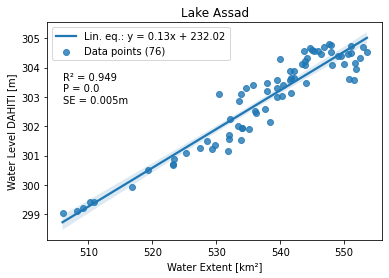

In [ ]:
sb.regplot(x = "water_extent_interp", y = "level_DAHITI",  data = df_matched_corr)
plt.xlabel("Water Extent [km²]")
plt.ylabel("Water Level DAHITI [m]")
plt.text(min(values[:,0]), max(values[:,1]-2), 'R² = {}\nP = {}\nSE = {}m'.format(r_squared, p_value, std_err))
plt.legend(labels=['Lin. eq.: y = {}x + {}'.format(slope, intercept), 'Data points ({})'.format(len(values[:,0]))])
plt.title('Lake ' +AOI_name)


Apply the model to get water level estimations

In [ ]:
df_water_extent['water_level_pred'] = df_water_extent['water_extent'] * slope + intercept
df_water_extent.head()

,date,water_extent,water_extent_interp,water_level_pred
2017-05-08,2017-05-08,547.177893,547.177893,303.153126
2017-05-09,2017-05-09,NaN,547.235030,NaN
2017-05-10,2017-05-10,NaN,547.292167,NaN
2017-05-11,2017-05-11,NaN,547.349303,NaN
2017-05-12,2017-05-12,NaN,547.406440,NaN


Text(0.5, 1.0, 'Surface water extent')

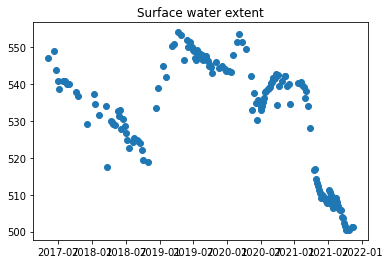

In [ ]:
plt.scatter(df_water_extent.index, df_water_extent['water_extent'])
plt.title('Surface water extent')


Text(0.5, 1.0, 'Water Level Estimations')

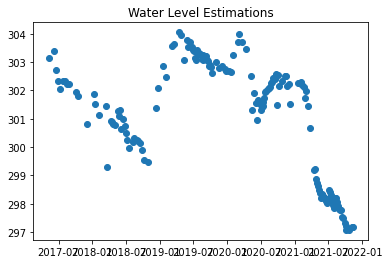

In [ ]:
plt.scatter(df_water_extent.index, df_water_extent['water_level_pred'])
plt.title('Water Level Estimations')

### Visualise and validate results 

#### Join in-situ dataset to df

In [ ]:
# df_in_situ.head()

In [ ]:
df_matched = df_water_extent.join(df_in_situ[AOI_dict[AOI_name]['dam_name'] + '_level']).join(df_DAHITI)
df_matched.head()

,date,water_extent,water_extent_interp,water_level_pred,Furat_level,level_DAHITI
2017-05-08,2017-05-08,547.177893,547.177893,303.153126,NaN,NaN
2017-05-09,2017-05-09,NaN,547.235030,NaN,NaN,NaN
2017-05-10,2017-05-10,NaN,547.292167,NaN,NaN,NaN
2017-05-11,2017-05-11,NaN,547.349303,NaN,NaN,NaN
2017-05-12,2017-05-12,NaN,547.406440,NaN,NaN,NaN


#### Visualise water levels
Compare estimated water levels with secondary Altimetry (water level) data (DAHITI) and in-situ data

In [ ]:
bbox_props = dict(boxstyle="square", fc="w", ec="0.5")

In [ ]:
label_pos_x = pd.to_datetime(AOI_dict[AOI_name]['start']) + timedelta(days=90)
label_pos_x

Timestamp('2017-04-01 00:00:00')

In [ ]:
labels = ['DAHITI estimates', 'REACH estimates', 'Offical measurements']


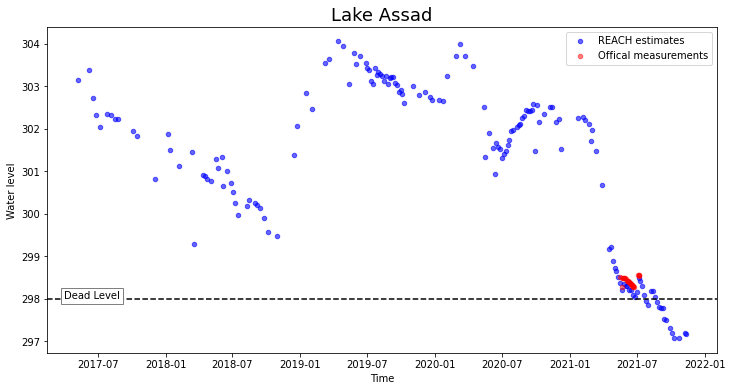

In [ ]:
ax = plt.gca()
# df_matched.plot(x ='date', y='level_DAHITI', color='g', alpha=0.8, kind = 'scatter',ax=ax, label=labels[0])
df_matched.plot(x ='date', y='water_level_pred', color='b', alpha=0.6, kind = 'scatter',ax=ax, label=labels[1])
df_matched.plot(x ='date', y=AOI_dict[AOI_name]['dam_name'] + '_level', color='r',  alpha=0.5, kind = 'scatter',ax=ax, label=labels[2],figsize=(12, 6))
plt.ylabel("Water level")
plt.xlabel("Time")
plt.axhline(y = dead_level, color = 'black', linestyle = 'dashed')
plt.title('Lake ' +AOI_name, fontsize=18)
plt.text(label_pos_x, dead_level, "Dead Level", backgroundcolor = 'white', bbox=bbox_props)
plt.show()

Zoom in to time period where in-situ data exists

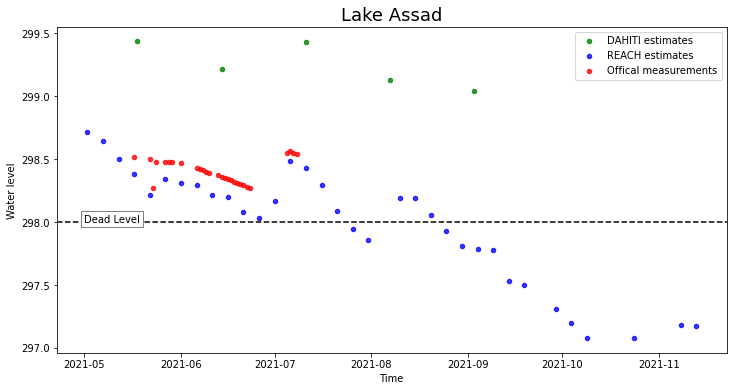

In [ ]:
df_masked = df_matched.loc[(df_matched['date'] > '2021-05-01') & (df_matched['date'] <= end)]

ax = plt.gca()

df_masked.plot(x ='date', y='level_DAHITI', color='g', alpha=0.8, kind = 'scatter',ax=ax, label=labels[0])
df_masked.plot(x ='date', y='water_level_pred', color='b', alpha=0.8,kind = 'scatter',ax=ax, label=labels[1])
df_masked.plot(x ='date', y=AOI_dict[AOI_name]['dam_name'] + '_level', color='r',alpha=0.8, kind = 'scatter',ax=ax, label=labels[2],figsize=(12, 6))
ax.legend()
plt.ylabel("Water level")
plt.xlabel("Time")
plt.axhline(y = dead_level, color = 'black', linestyle = 'dashed')
plt.text(pd.to_datetime('2021-05-01'), dead_level, "Dead Level", backgroundcolor = 'white', bbox=bbox_props)

plt.title('Lake ' +AOI_name, fontsize=18)
plt.show()

#### How much do our estimates deviate from the DAHITI estimates?

In [ ]:
df_water_extent['water_level_pred_interp'] = df_water_extent['water_level_pred'].interpolate(method ='linear', limit_direction ='forward')

df_dev = df_water_extent.join(df_DAHITI)[['level_DAHITI', 'water_level_pred_interp']].dropna() 
print('Number of matched observations: ', len(df_dev))

df_dev['diff'] = df_dev['water_level_pred_interp'] - df_dev['level_DAHITI']

mean = df_dev['diff'].mean()
print(mean)
mean_str = str(mean)[0:5] + str(mean)[-4:]
mean_str

Number of matched observations:  48
0.21144352007176911


'0.2116911'

Text(0.5, 1.0, 'Deviations Estimated - DAHITI')

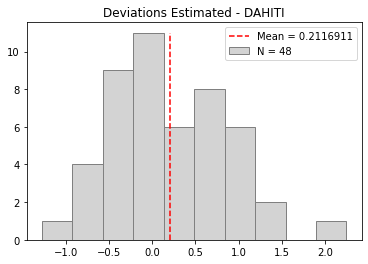

In [ ]:
y, x, _ = plt.hist(df_dev['diff'], color='lightgrey',edgecolor = 'grey') 
plt.vlines(mean,0,y.max(), colors='red',linestyles='dashed')
plt.legend(['Mean = {}'.format(mean_str),'N = {}'.format(len(df_dev['diff']))])
plt.title('Deviations Estimated - DAHITI')

Text(0.5, 1.0, 'Deviations Estimated - DAHITI')

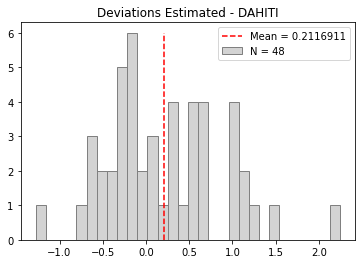

In [ ]:
y, x, _ = plt.hist(df_dev['diff'], bins=30, color='lightgrey',edgecolor = 'grey')
plt.vlines(mean,0,y.max(), colors='red',linestyles='dashed')

plt.legend(['Mean = {}'.format(mean_str),'N = {}'.format(len(df_dev['diff']))])
plt.title('Deviations Estimated - DAHITI')

In [ ]:
# Calculate percentiles
quant_5, quant_25, quant_50, quant_75, quant_95 = df_dev['diff'].quantile(0.05), df_dev['diff'].quantile(0.25), df_dev['diff'].quantile(0.5), df_dev['diff'].quantile(0.75), df_dev['diff'].quantile(0.95)
print('Percentiles: ', quant_5, quant_25, quant_50, quant_75, quant_95)

Percentiles:  -0.6044273318718723 -0.2730473771976989 0.08624594181912926 0.6188720083774797 1.2045606276558571


Text(0.9545606276558571, 0.17, '95th Percentile')

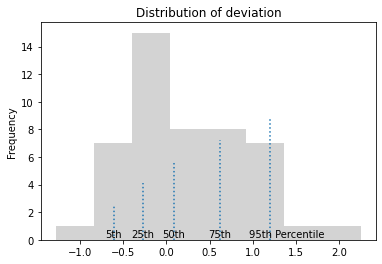

In [ ]:
fig, ax = plt.subplots(figsize = (6,4))
df_dev['diff'].plot(kind = "hist", bins=8, color = 'lightgrey')
ax.set_title('Distribution of deviation')

# [quantile, opacity, length]
quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]

# Plot the lines with a loop
for i in quants:
    ax.axvline(i[0], ymax = i[2], linestyle = ":")

ax.text(quant_5-.1, 0.17, "5th", size = 10,)
ax.text(quant_25-.13, 0.17, "25th", size = 10)
ax.text(quant_50-.13, 0.17, "50th", size = 10)
ax.text(quant_75-.13, 0.17, "75th", size = 10)
ax.text(quant_95-.25, 0.17, "95th Percentile", size = 10)

#### How much do our estimates deviate from the official measurements?

In [ ]:
df_dev = df_water_extent.join(df_in_situ[AOI_dict[AOI_name]['dam_name'] + '_level'])[[AOI_dict[AOI_name]['dam_name'] + '_level', 'water_level_pred_interp']].dropna() 
print('Number of matched observations: ', len(df_dev))

df_dev['diff'] = df_dev['water_level_pred_interp'] - df_dev[AOI_dict[AOI_name]['dam_name'] + '_level']
df_dev.head()

Number of matched observations:  28


,Tishrin_level,water_level_pred_interp,diff
2021-05-17,321.28,321.800072,0.520072
2021-05-22,321.32,321.825896,0.505896
2021-05-23,321.16,321.836066,0.676066
2021-05-24,321.31,321.846237,0.536237
2021-05-27,321.33,321.876747,0.546747
2021-05-28,321.20,321.858866,0.658866
2021-05-29,321.31,321.840985,0.530985
2021-06-01,321.33,321.787342,0.457342
2021-06-06,321.39,321.781709,0.391709
2021-06-07,321.38,321.780583,0.400583


In [ ]:
mean = round(df_dev['diff'].mean(),4)
mean

0.6443

Text(0.5, 1.0, 'Deviations Estimated - Official')

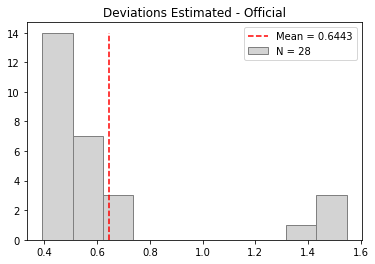

In [ ]:
y, x, _ = plt.hist(df_dev['diff'], color='lightgrey',edgecolor = 'grey')
plt.vlines(mean,0,y.max(), colors='red',linestyles='dashed')
plt.legend(['Mean = {}'.format(mean),'N = {}'.format(len(df_dev['diff']))])
plt.title('Deviations Estimated - Official')

Regress our estimates with official measurements

In [ ]:
values_ = df_dev[["water_level_pred_interp", AOI_dict[AOI_name]['dam_name'] + '_level']].to_numpy()



In [ ]:
slope, intercept, r_value, p_value, std_err = linregress(values_[:,0], values_[:,1])

r_sq = round(r_value*r_value, 2)
p_val = round(p_value, 2)
SE = round(std_err, 2)
slope_rounded = round(slope, 2)
interc = round(intercept, 2)

Text(0.5, 1.0, 'Lake Tishrin')

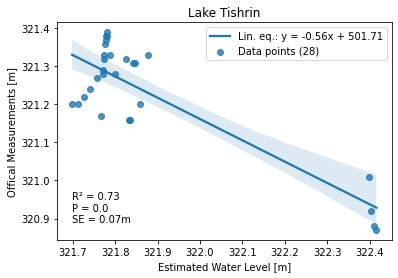

In [ ]:
if (AOI_name == 'Tishrin'): y_pos = 0.5
else: y_pos = 0.1
sb.regplot(x = 'water_level_pred_interp', y = AOI_dict[AOI_name]['dam_name'] + '_level',  data = df_dev)
plt.xlabel("Estimated Water Level [m]")
plt.ylabel("Offical Measurements [m]")


plt.text(min(values_[:,0]), max(values_[:,1]-y_pos), 'R² = {}\nP = {}\nSE = {}m'.format(r_sq, p_val, SE)) 

plt.legend(labels=['Lin. eq.: y = {}x + {}'.format(slope_rounded, interc), 'Data points ({})'.format(len(values_[:,0]))])
plt.title('Lake ' +AOI_name)

#### Adjust water level values to in-situ data

Select time period where in-situ data exists

In [ ]:
 df_adjust = df_matched.loc[(df_matched['date'] >= df_in_situ.index.min()) & (df_matched['date'] <= df_in_situ.index.max())][['water_level_pred', AOI_dict[AOI_name]['dam_name'] + '_level']]

In [ ]:
df_adjust.head(10)

,water_level_pred,Tishrin_level
2021-05-17,321.800072,321.28
2021-05-18,NaN,NaN
2021-05-19,NaN,NaN
2021-05-20,NaN,NaN
2021-05-21,NaN,NaN
2021-05-22,321.825896,321.32
2021-05-23,NaN,321.16
2021-05-24,NaN,321.31
2021-05-25,NaN,NaN
2021-05-26,NaN,NaN


Interpolate estimated water levels on daily basis and drop days without in-situ data 

In [ ]:
df_adjust['water_level_pred'] = df_adjust['water_level_pred'].interpolate(method ='linear', limit_direction ='forward')
df_adjust.head(10)

,water_level_pred,Tishrin_level
2021-05-17,321.639488,321.28
2021-05-18,321.644559,NaN
2021-05-19,321.649630,NaN
2021-05-20,321.654701,NaN
2021-05-21,321.659772,NaN
2021-05-22,321.664843,321.32
2021-05-23,321.674829,321.16
2021-05-24,321.684814,321.31
2021-05-25,321.694800,NaN
2021-05-26,321.704785,NaN


In [ ]:
df_adjust = df_adjust.dropna() # drop rows with no data 
print('Number of matched observations: ', len(df_adjust))

Number of matched observations:  28


Calculate the mean of both datasets and subtract the difference of the mean from estimated water levels and secondary Altimetry (water level) data. Append as new columns to the df

In [ ]:
mean_diff = df_adjust.mean()['water_level_pred'] - df_adjust.mean()[AOI_dict[AOI_name]['dam_name'] + '_level']
print('difference of the mean: ', mean_diff)
df_matched['water_level_pred_adj'] = df_matched['water_level_pred'] - mean_diff
df_matched['level_DAHITI_adj'] = df_matched['level_DAHITI'] - mean_diff
df_matched.head()

difference of the mean:  0.47767063346935856


,date,water_extent,water_extent_interp,water_level_pred,Tishrin_level,level_DAHITI,water_level_pred_adj,level_DAHITI_adj
2018-12-29,2018-12-29,60.378395,60.378395,325.163731,NaN,NaN,324.68606,NaN
2018-12-30,2018-12-30,NaN,60.285366,NaN,NaN,NaN,NaN,NaN
2018-12-31,2018-12-31,NaN,60.192337,NaN,NaN,NaN,NaN,NaN
2019-01-01,2019-01-01,NaN,60.099308,NaN,NaN,NaN,NaN,NaN
2019-01-02,2019-01-02,NaN,60.006279,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_adjust.mean()['water_level_pred']

df_adjust.mean()[AOI_dict[AOI_name]['dam_name'] + '_level']


321.23142857142847

#### Visualise adjusted water levels

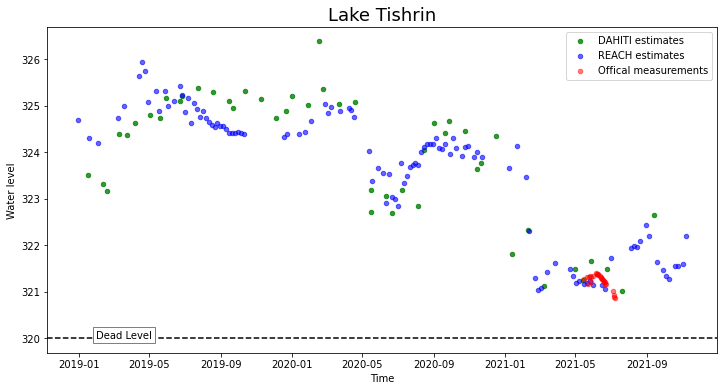

In [ ]:
ax = plt.gca()
df_matched.plot(x ='date', y='level_DAHITI_adj', color='g', alpha=0.8, kind = 'scatter',ax=ax, label=labels[0])
df_matched.plot(x ='date', y='water_level_pred_adj', color='b', alpha=0.6, kind = 'scatter',ax=ax, label=labels[1])
df_matched.plot(x ='date', y=AOI_dict[AOI_name]['dam_name'] + '_level', color='r',  alpha=0.5, kind = 'scatter',ax=ax, label=labels[2],figsize=(12, 6))
plt.ylabel("Water level")
plt.xlabel("Time")
plt.axhline(y = dead_level, color = 'black', linestyle = 'dashed')
plt.text(label_pos_x, dead_level, "Dead Level", backgroundcolor = 'white', bbox=bbox_props)
plt.title('Lake ' +AOI_name, fontsize=18)
plt.show()

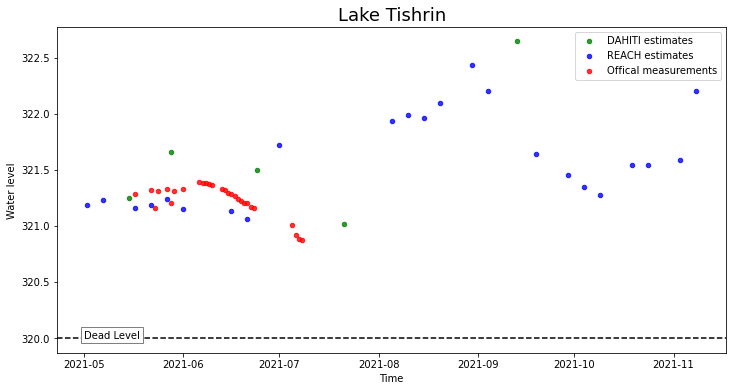

In [ ]:
df_masked = df_matched.loc[(df_matched['date'] > '2021-05-01') & (df_matched['date'] <= end)]

ax = plt.gca()


df_masked.plot(x ='date', y='level_DAHITI_adj', color='g', alpha=0.8, kind = 'scatter',ax=ax, label=labels[0])
df_masked.plot(x ='date', y='water_level_pred_adj', color='b', alpha=0.8,kind = 'scatter',ax=ax, label=labels[1])
df_masked.plot(x ='date', y=AOI_dict[AOI_name]['dam_name'] + '_level', color='r',alpha=0.8, kind = 'scatter',ax=ax, label=labels[2],figsize=(12, 6))
ax.legend()
plt.ylabel("Water level")
plt.xlabel("Time")
plt.axhline(y = dead_level, color = 'black', linestyle = 'dashed')
plt.text(pd.to_datetime('2021-05-01'), dead_level, "Dead Level", backgroundcolor = 'white', bbox=bbox_props)
plt.title('Lake ' + AOI_name, fontsize=18)
plt.show()

#### Visualise surface water **extent**


In [ ]:
### Dam Tabqa: on 2021/06/22 water level was 0.28 m above its dead level
# water_extent_close_to_dead = df_matched.loc[dt.datetime(2021, 6, 22),'water_extent_interp']

### Dam Tishrin: on 2021/07/08 water level was 1.17 m above its dead level
water_extent_close_to_dead= df_matched.loc[dt.datetime(2021, 7, 8),'water_extent_interp']

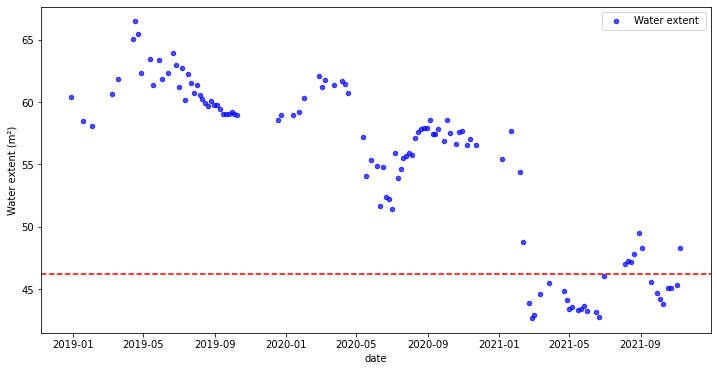

In [ ]:
ax = plt.gca()

df_matched.plot(x ='date', y='water_extent', color='b',alpha=0.7, kind = 'scatter',ax=ax, label='Water extent ',figsize=(12, 6))

plt.ylabel("Water extent (m²)")
plt.axhline(y = water_extent_close_to_dead, color = 'red', linestyle = 'dashed' )

plt.show()

## Download water level estimates as CSV file

In [ ]:
df_matched['water_level_pred'].dropna()

2017-05-08    304.168869
2017-06-07    304.394894
2017-06-17    303.739554
2017-06-27    303.324350
2017-07-07    303.037508
                 ...    
2021-09-04    298.728136
2021-09-19    298.432647
2021-09-29    298.239823
2021-10-04    298.130027
2021-10-09    298.007541
Name: water_level_pred, Length: 157, dtype: float64

In [ ]:
df_matched['water_level_pred'].dropna().to_csv("water_level_estimates_" + AOI_name +".csv")

from google.colab import files
files.download("water_level_estimates_" + AOI_name +".csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Estimate water level based on the most recent Sentinel-2 image

In [ ]:
AOI_name = 'Assad' # Assad or Tishrin

### Extract Sentinel-2

In [ ]:

AOI_dict = {'Assad': {'poi': dam_Tabqa, 'aoi': AOI_Assad, 'slope': 0.2061884746420752, 'intercept': 232.01701010725805}, # r = 0.946, p = 4.78-38
          'Tishrin': {'poi': dam_Tishrin, 'aoi': AOI_Tishrin, 'slope': 0.1318617946797237 , 'intercept': 312.7144016064514}}


aoi = AOI_dict[AOI_name]['aoi']
poi = AOI_dict[AOI_name]['poi']


In [ ]:
# get image 
start = (datetime.today() - timedelta(days=6)).strftime("%Y-%m-%d")
end = datetime.today().strftime("%Y-%m-%d")

start_date = ee.Date(start)
end_date = ee.Date(end)

# Loading and filtering image collections
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR')\
                    .filterDate(start_date, end_date) 
               
sentinel2 = sentinel2.filterBounds(poi).sort('system:time_start', False) # sort so the newest image is in the first position

print('Most recent date:', sentinel2.first().date().format('YYYY-MM-dd').getInfo())

In [ ]:
sentinel2.size().getInfo()

### Pre-process Sentinel-2

In [ ]:
AOI = aoi
START_DATE = start;
END_DATE = end;

CLOUD_FILTER = 50;        
CLD_PRB_THRESH = 40;    
NIR_DRK_THRESH = 0.19;      
CLD_PRJ_DIST = 3.3;         
BUFFER = 33;

s2_sr_col = sentinel2.filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER));
print(s2_sr_col.size().getInfo())
s2_sr_cld_col_eval = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)
print(s2_sr_cld_col_eval.size().getInfo())

s2_cloudMaskAdded = s2_sr_cld_col_eval.map(add_cld_shdw_mask)
print(s2_cloudMaskAdded.size().getInfo())
s2_cloudMaskAdded = s2_cloudMaskAdded.map(lambda img: img.clip(aoi)).map(add_cloud_percentage) # cloud percentage within AOI



In [ ]:
### filter out cloudy images from AOI based on threshold (in %)
cloud_perc_th = 0.01
s2_filtered = s2_cloudMaskAdded.filterMetadata('cloud_perc', 'less_than', cloud_perc_th)

# problem is that MNDWI has holes because B11 has holes (masked values)
# fill B11 masked values with 1000 so that MNDWI is negative and we can use water = water_MNDWI.or(water_NDWI) to return only NDWI. If pixel in water_MNDWI is masked, it returns masked, not water_NDWI.
s2_filtered = s2_filtered.map(lambda image: image.addBands(image.select('B11').unmask(1000).rename('B11_filled')))


### calculate indices
s2_filtered = s2_filtered.map(lambda image: image.addBands(image.normalizedDifference(['B3','B11_filled']).rename('MNDWI'))\
                              .addBands(image.normalizedDifference(['B8','B3']).rename('NDWI')))
        

In [ ]:
s2_filtered.size().getInfo()

 ### Compute surface water extent 






Compute water extent and add as property to each image

In [ ]:
s2_filtered = s2_filtered.map(add_water_extent)

In [ ]:


# estimate water level based on linear model 